<a href="https://colab.research.google.com/github/leonardoacosta91/PrediccionACV/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,RMSprop
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

In [ ]:
#https://www.kaggle.com/fedesoriano/stroke-prediction-dataset
raw_stroke = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stroke Prediction/healthcare-dataset-stroke-data.csv")
raw_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Attribute Information  
1) id: unique identifier  
2) gender: "Male", "Female" or "Other"   
3) age: age of the patient   
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension   
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease   
6) ever_married: "No" or "Yes"   
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"   
8) Residence_type: "Rural" or "Urban"    
9) avg_glucose_level: average glucose level in blood    
10) bmi: body mass index    
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*   
12) stroke: 1 if the patient had a stroke or 0 if not   
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

# Visualization functions

In [ ]:
def barPlot(dataframe,title,xLabel,xColumn,yLabel,yColumn="",hue=False,hue_column=""):
  plt.figure(figsize=(8,5))
  if hue:
    ax = sns.barplot(x=xColumn,y=yColumn,hue=hue_column,data=dataframe,palette="Blues_d")
  else:
    ax = sns.barplot(x=xColumn,y=yColumn,data=dataframe,palette="Blues_d")
  ax.axes.set_title(title,fontsize=20)
  ax.set_xlabel(xLabel,fontsize=15)
  ax.set_ylabel(yLabel,fontsize=15)
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
  for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

def barPlotPercentage(dataframe,title,xLabel,xColumn,yLabel,yColumn="",hue=False,hue_column=""):
  grouped = dataframe.groupby(xColumn)[xColumn].size().reset_index(name='Quantity')
  grouped['Percentage'] = grouped.apply(lambda row: round(row['Quantity']*100 / len(dataframe),2),axis=1)
  barPlot(grouped,title,xLabel,xColumn,yLabel,'Percentage',hue,hue_column)

def linePlot(dataframe,title,xColumn,xLabel,yColumn,yLabel,optional_hue="none"):
  plt.figure(figsize=(14,6))
  if optional_hue is not "none":
    ax = sns.lineplot(data=dataframe,x=xColumn,y=yColumn,hue=optional_hue)
  else:
    ax = sns.lineplot(data=dataframe,x=xColumn,y=yColumn)
  ax.axes.set_title(title,fontsize=20)
  ax.set_xlabel(xLabel,fontsize=15)
  ax.set_ylabel(yLabel,fontsize=15)

def pieChart(dataframe,title,size,labels):
  plt.figure(figsize=(7,7))
  plt.pie(x=dataframe[size],autopct="%.1f%%",labels=dataframe[labels],pctdistance=0.7)
  plt.title(title,fontsize=20)

def donutChart(dataframe,title,size,labels):
  plt.figure(figsize=(7,7))
  plt.pie(x=dataframe[size],autopct="%.2f%%",labels=dataframe[labels],pctdistance=0.7)
  plt.title(title,fontsize=20)
  #draw a circle at the center of pie to make it look like a donut
  centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=1.25)
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)
  # Set aspect ratio to be equal so that pie is drawn as a circle.
  plt.axis('equal')
  plt.show()

def scatterPlot(dataframe,title,xColumn,xLabel,yColumn,yLabel,linea=False):
  plt.figure(figsize=(14,6))
  if linea:
    ax = sns.regplot(data = dataframe, x = xColumn, y = yColumn)
  else:
    ax = sns.scatterplot(data = dataframe, x = xColumn, y = yColumn)
  ax.axes.set_title(title,fontsize=15)
  ax.set_xlabel(xLabel,fontsize=10)
  ax.set_ylabel(yLabel,fontsize=10)

def histPlot(dataframe,xColumn,xLabel,bins=15):
  plt.figure(figsize=(7,7))
  sns.distplot(dataframe[xColumn],kde=True,color="blue", label=xColumn,bins=bins)
  plt.xlabel(xLabel, fontsize=12)
  plt.margins(x=0,y=0)
  plt.show()


# Data Exploration

In [ ]:
raw_stroke.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## Stroke

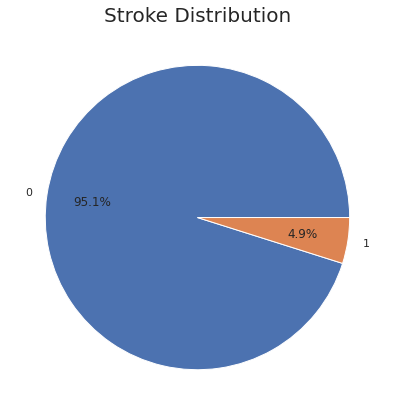

In [ ]:
strokeTotal = raw_stroke.groupby("stroke")["stroke"].size().reset_index(name="Quantity")
pieChart(strokeTotal,"Stroke Distribution","Quantity","stroke")

## Gender

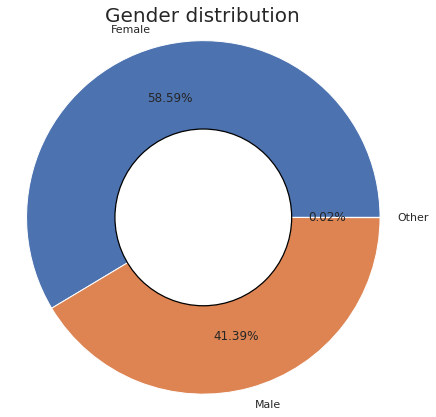

In [ ]:
genderQuantity = raw_stroke.groupby(['gender'])['gender'].count().reset_index(name='Quantity')
donutChart(genderQuantity,"Gender distribution","Quantity",'gender')

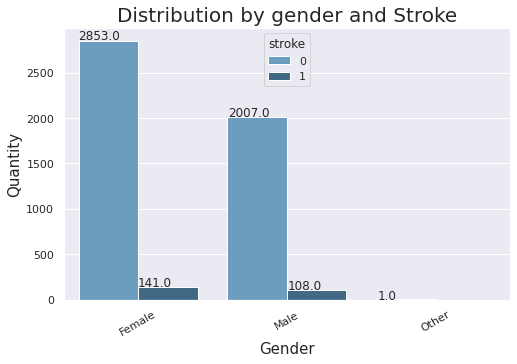

In [ ]:
genderStrokeQuantity = raw_stroke.groupby(['gender','stroke'])[['gender','stroke']].size().reset_index(name='Quantity')
barPlot(genderStrokeQuantity,"Distribution by gender and Stroke","Gender","gender","Quantity","Quantity",True,"stroke")

## Age

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


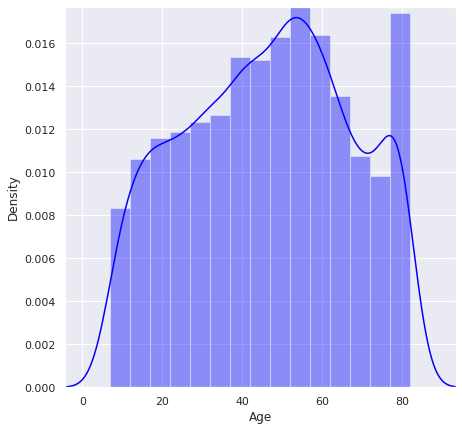

In [ ]:
histPlot(raw_stroke[raw_stroke['age'] > 6],'age','Age')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


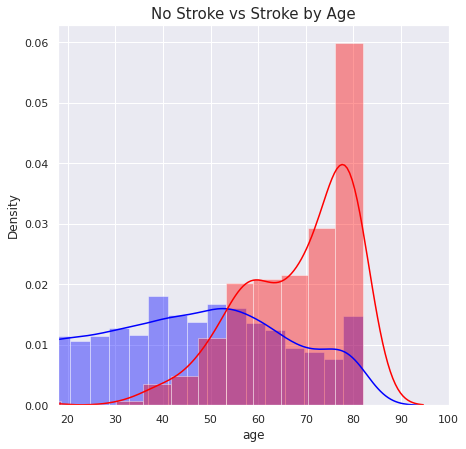

In [ ]:
plt.figure(figsize=(7,7))

sns.distplot(raw_stroke[raw_stroke['stroke'] == 0]["age"], color='blue') # No Stroke - green
sns.distplot(raw_stroke[raw_stroke['stroke'] == 1]["age"], color='red') # Stroke - Red
#plt.legend()
plt.title('No Stroke vs Stroke by Age', fontsize=15)
plt.xlim([18,100])
plt.show()

## hypertension

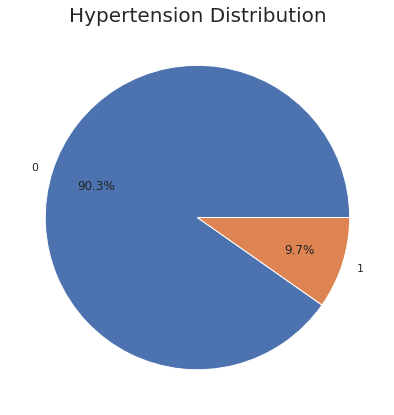

In [ ]:
hypertension = raw_stroke.groupby("hypertension")["hypertension"].size().reset_index(name="Quantity")
pieChart(hypertension,"Hypertension Distribution","Quantity","hypertension")

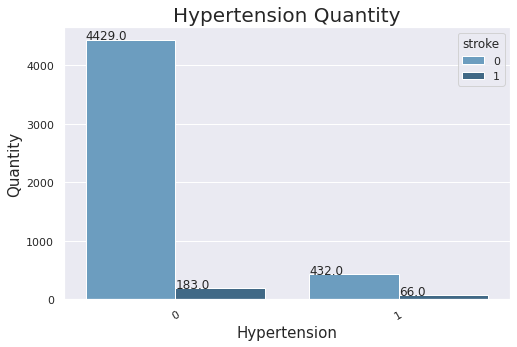

In [ ]:
hypertensionStrokeQuantity = raw_stroke.groupby(['hypertension','stroke'])[['hypertension']].size().reset_index(name='Quantity')
barPlot(hypertensionStrokeQuantity,"Hypertension Quantity","Hypertension","hypertension","Quantity","Quantity",True,"stroke")

## heart_disease

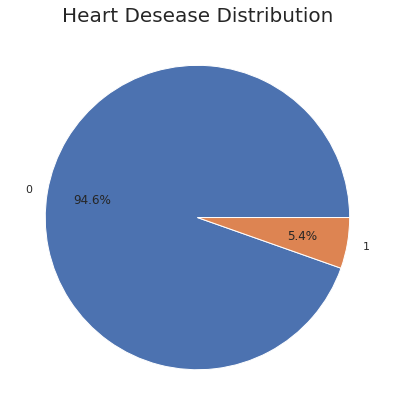

In [ ]:
heart = raw_stroke.groupby("heart_disease")["heart_disease"].size().reset_index(name="Quantity")
#heart.heart_disease = heart.heart_disease.map({0:"No",1:"Si"})
pieChart(heart,"Heart Desease Distribution","Quantity","heart_disease")
#heartDeseaseQuantity = raw_stroke.groupby(['heart_disease'])['heart_disease'].size().reset_index(name='Quantity')
#barPlot(heartDeseaseQuantity,"Heart Desease Quantity","heart_disease","heart_disease","Quantity","Quantity")

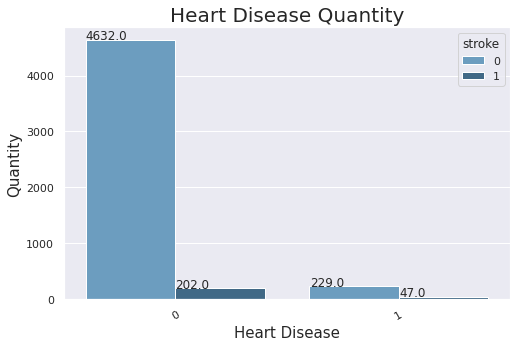

In [ ]:
heartDiseaseStrokeQuantity = raw_stroke.groupby(['heart_disease','stroke'])[['heart_disease']].size().reset_index(name='Quantity')
barPlot(heartDiseaseStrokeQuantity,"Heart Disease Quantity","Heart Disease","heart_disease","Quantity","Quantity",True,"stroke")

## ever_married

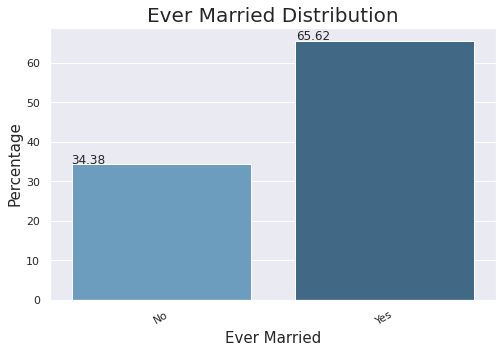

In [ ]:
barPlotPercentage(raw_stroke,"Ever Married Distribution","Ever Married","ever_married","Percentage")

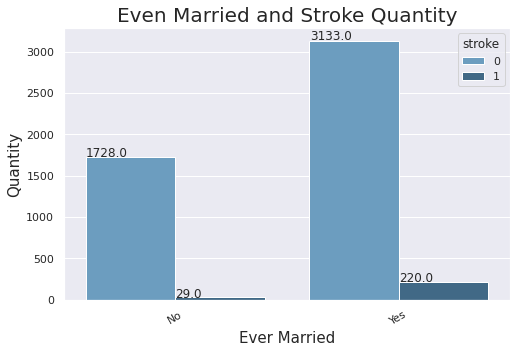

In [ ]:
marriedStrokeQuantity = raw_stroke.groupby(['ever_married','stroke'])[['ever_married']].size().reset_index(name='Quantity')
barPlot(marriedStrokeQuantity,"Even Married and Stroke Quantity","Ever Married","ever_married","Quantity","Quantity",True,"stroke")

## work_type

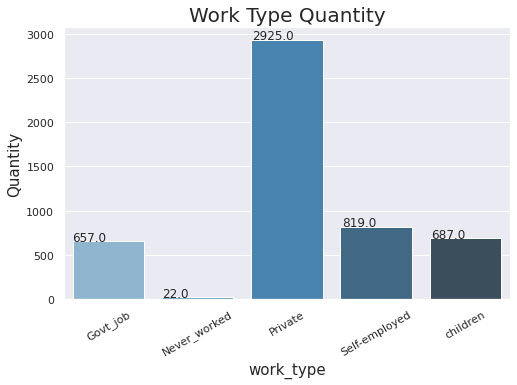

In [ ]:
workTypeQuantity = raw_stroke.groupby(['work_type'])['work_type'].size().reset_index(name='Quantity')
barPlot(workTypeQuantity,"Work Type Quantity","work_type","work_type","Quantity","Quantity")

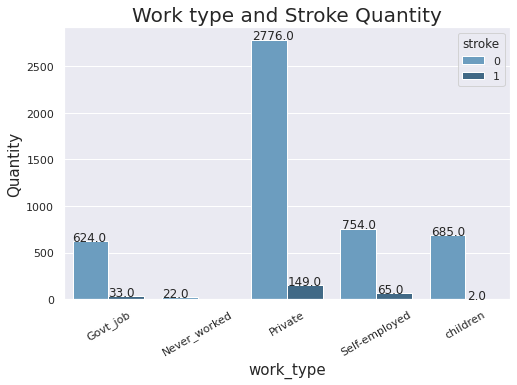

In [ ]:
workStrokeQuantity = raw_stroke.groupby(['work_type','stroke'])[['work_type']].size().reset_index(name='Quantity')
barPlot(workStrokeQuantity,"Work type and Stroke Quantity","work_type","work_type","Quantity","Quantity",True,"stroke")

## bmi

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


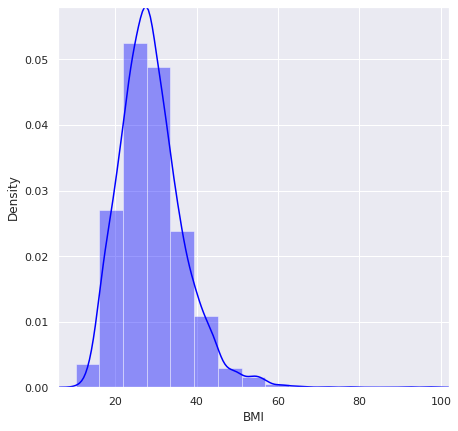

In [ ]:
histPlot(raw_stroke,'bmi','BMI')

## smoking_status

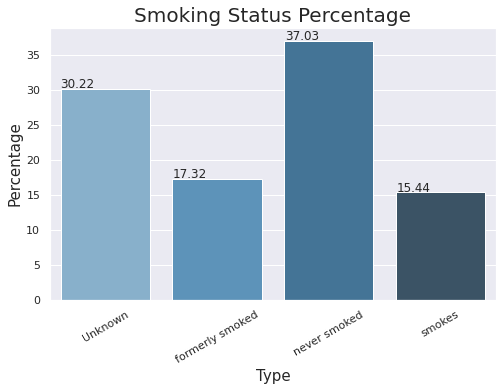

In [ ]:
barPlotPercentage(raw_stroke,"Smoking Status Percentage","Type","smoking_status","Percentage")

## avg_glucose_level

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


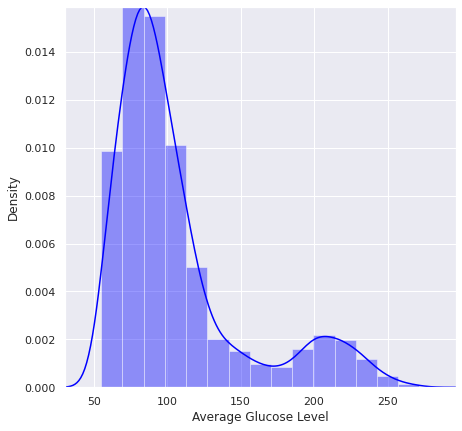

In [ ]:
histPlot(raw_stroke,'avg_glucose_level','Average Glucose Level')

## residence_type

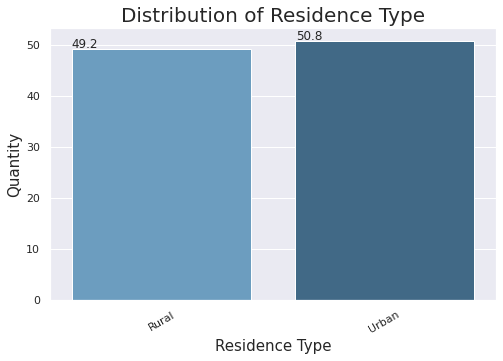

In [ ]:
barPlotPercentage(raw_stroke,"Distribution of Residence Type","Residence Type","Residence_type","Quantity")

# Data PreProcessing

## Functions

In [ ]:
def getOutlierInformationInDataframe(dataframe):
  nonBinaryColumns = getNonBinaryNumericCols(dataframe)
  outliers=[]
  for column in nonBinaryColumns:
    lower,upper = getOutlierData(dataframe,column)
    dataframe_with_outliers = dataframe[(dataframe[column] > upper) | (dataframe[column] < lower)][column] 
    if len(dataframe_with_outliers) > 0:
      outliers.append([column,len(dataframe_with_outliers)])
  print(outliers)

def getOutlierData(dataframe,column):
    std = dataframe[column].std()
    mean = dataframe[column].mean()
    cut_off = std*3
    lower = mean - cut_off 
    upper = mean + cut_off
    return lower,upper

def getNonBinaryNumericCols(dataframe):
  numeric = dataframe.select_dtypes('number').columns
  NumericDF = dataframe[numeric]
  nonBinaryColumns = NumericDF.columns[~NumericDF.isin([0,1]).all()]
  return nonBinaryColumns

def dataframeWithoutOutlierInColumn(dataframe,column):
  lower,upper = getOutlierData(dataframe,column)
  return dataframe[(dataframe[column] < upper) & (dataframe[column] > lower)]

def dummifyColumn(dataframe,column,dropFrist):
  dummy_column = pd.get_dummies(dataframe[column], prefix=column,drop_first=dropFrist) 
  dfWithoutColumn = dataframe.drop(column,axis=1) 
  dataFrameWithDummy = pd.concat([dfWithoutColumn,dummy_column],axis=1)
  return dataFrameWithDummy

def dummifyDataframe(dataframe,columns,dropFirst=True):
  tempDf = dataframe.copy()
  for column in columns:
    tempDf = dummifyColumn(tempDf,column,dropFirst)
  return tempDf

def scaledNumericColsInDataframe(dataframe,columns):
  ss = StandardScaler()
  retDataframe = dataframe.copy()
  retDataframe[columns] = ss.fit_transform(retDataframe[columns])
  return retDataframe

def classificationMatrix(y_true,y_pred):
  cf_matrix = confusion_matrix(y_true, y_pred)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  print(classification_report(y_true,y_pred))
  print("="*50)

def rocCourveDisplay(y_test,y_proba,model):
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba)
  plt.plot(false_positive_rate, true_positive_rate, marker='.', label=model)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  print("="*50)

In [ ]:
raw_stroke.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

## Data Wrangling

In [ ]:
#Drop ID column
rawWithoutId = raw_stroke.drop("id",axis=1)

In [ ]:
#Change smoking status to numerical
dict_smoking_status = {'never smoked':0,'Unknown':1,'formerly smoked':2,'smokes':3}
rawWithoutId['smoking_status'] = rawWithoutId.smoking_status.map(dict_smoking_status)

In [ ]:
#Fill NA values with median
rawWithoutId['bmi'] = rawWithoutId['bmi'].fillna(rawWithoutId['bmi'].median())

In [ ]:
#Filter df to drop the only row with gender "other"
rawGenderDropNone = rawWithoutId[rawWithoutId['gender'] != 'Other']

In [ ]:
#Get info from outliers
getOutlierInformationInDataframe(rawGenderDropNone)

[['avg_glucose_level', 49], ['bmi', 59]]


In [ ]:
#Drop lines with outliers
stroke_noOutliersBmi = dataframeWithoutOutlierInColumn(rawGenderDropNone,'bmi')
print("Dataframe with outliers in column: {} \nDataframe without Outliers in column {}".format(rawGenderDropNone.shape[0],stroke_noOutliersBmi.shape[0]))

Dataframe with outliers in column: 5109 
Dataframe without Outliers in column 5050


In [ ]:
stroke_noOutliersGlucose = dataframeWithoutOutlierInColumn(stroke_noOutliersBmi,'avg_glucose_level')
print("Dataframe with outliers in column: {} \nDataframe without Outliers in column {}".format(stroke_noOutliersBmi.shape[0],stroke_noOutliersGlucose.shape[0]))

Dataframe with outliers in column: 5050 
Dataframe without Outliers in column 5001


In [ ]:
#Get numerical and categorical columns
numericCols = getNonBinaryNumericCols(stroke_noOutliersGlucose)
categoricalCols = stroke_noOutliersGlucose.select_dtypes('object').columns

print(numericCols)
print(categoricalCols)

Index(['age', 'avg_glucose_level', 'bmi', 'smoking_status'], dtype='object')
Index(['gender', 'ever_married', 'work_type', 'Residence_type'], dtype='object')


In [ ]:
#Remove smoking status because is already encoded
numericCols = numericCols.drop('smoking_status')

In [ ]:
#Dummify columns 
strokeFinal = dummifyDataframe(stroke_noOutliersGlucose,categoricalCols,True)

In [ ]:
strokeFinal.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban
0,67.0,0,1,228.69,36.6,2,1,1,1,0,1,0,0,1
1,61.0,0,0,202.21,28.1,0,1,0,1,0,0,1,0,0
2,80.0,0,1,105.92,32.5,0,1,1,1,0,1,0,0,0
3,49.0,0,0,171.23,34.4,3,1,0,1,0,1,0,0,1
4,79.0,1,0,174.12,24.0,0,1,0,1,0,0,1,0,0


## Correlation

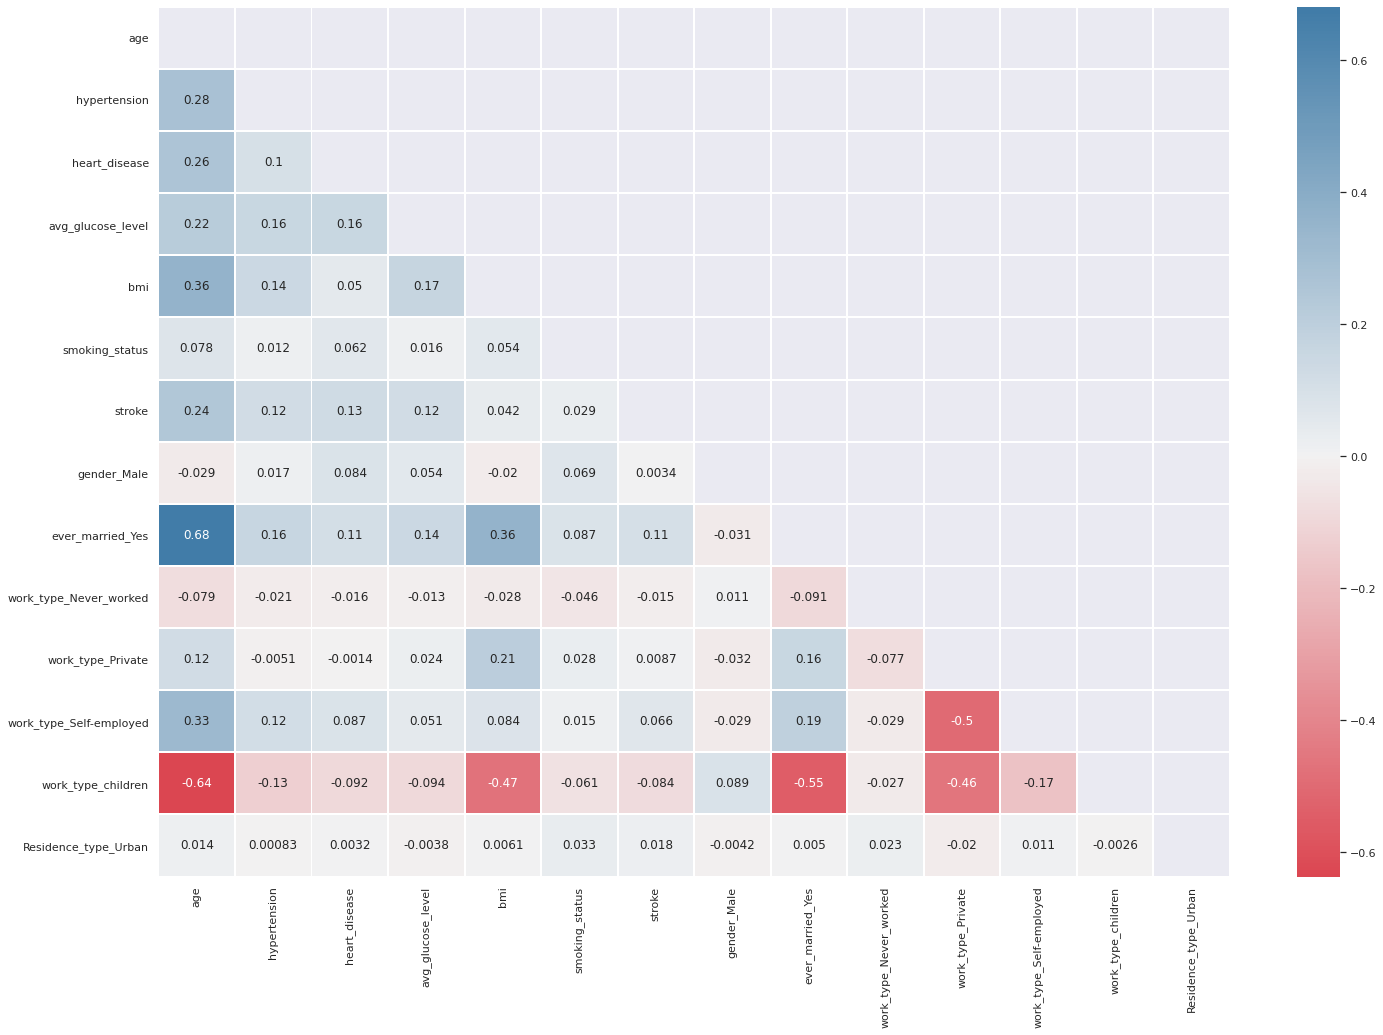

In [ ]:
#Creating and display correlation matrix
corr_df = strokeFinal.corr(method='pearson')
cmap = sns.diverging_palette(h_neg=10,h_pos=240,as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(24, 16))
sns.heatmap(corr_df,cmap=cmap,mask=mask,center=0, linewidths=1, annot=True)
plt.show()

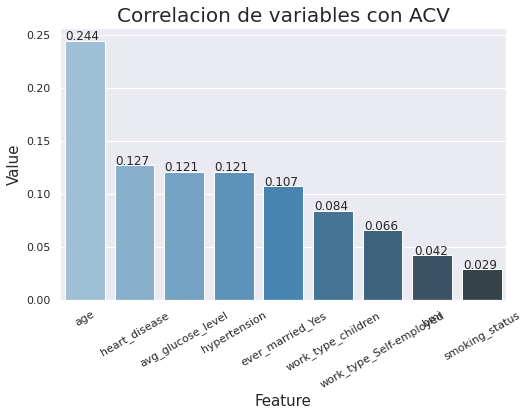

In [ ]:
correlacion = corr_df['stroke'].round(decimals=3).abs().sort_values(ascending=False).reset_index()[1:10]
barPlot(correlacion,"Correlacion de variables con ACV","Feature","index","Value","stroke")

# Machine Learning

## Data Preparation

In [ ]:
X = strokeFinal.drop("stroke",axis=1)
y = strokeFinal['stroke']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42,stratify=y)

In [ ]:
ss = StandardScaler()
X_train[numericCols] = ss.fit_transform(X_train[numericCols])
X_test[numericCols] = ss.transform(X_test[numericCols])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

sm = SMOTE(random_state=2)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
X_train_smote = pd.DataFrame(X_train_smote,columns=X_train.columns)

print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote==0)))

Before OverSampling, counts of label '1': 239
Before OverSampling, counts of label '0': 4762 

After OverSampling, the shape of train_X: (7142, 13)
After OverSampling, the shape of train_y: (7142,) 

After OverSampling, counts of label '1': 3571
After OverSampling, counts of label '0': 3571


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Test with Logistic Regression to see Coheficients

In [ ]:
testLR = LogisticRegression(class_weight='balanced')
testLR.fit(X_train_smote,y_train_smote)

y_pred = testLR.predict(X_test)

# Prints accuracy metrics and feature coefficients
print("{0:.1%} recall on test set.".format(recall_score(y_test, y_pred))) 
print("Coefficients: "+ str(dict(zip(X.columns, abs(testLR.coef_[0]).round(2)))))

78.3% recall on test set.
Coefficients: {'age': 2.08, 'hypertension': 0.03, 'heart_disease': 0.13, 'avg_glucose_level': 0.18, 'bmi': 0.0, 'smoking_status': 0.22, 'gender_Male': 0.07, 'ever_married_Yes': 0.39, 'work_type_Never_worked': 0.14, 'work_type_Private': 0.3, 'work_type_Self-employed': 0.07, 'work_type_children': 0.75, 'Residence_type_Urban': 0.11}


Optimal number of features : 4
76.7% recall on test set.


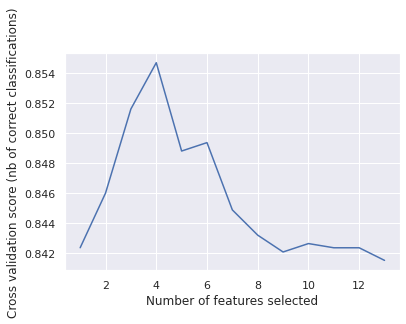

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

testLR = LogisticRegression(class_weight='balanced')
min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(estimator=testLR, step=1, cv=StratifiedKFold(5),
              scoring='recall',
              min_features_to_select=min_features_to_select)

rfecv.fit(X_train_smote,y_train_smote)
print("Optimal number of features : %d" % rfecv.n_features_)
y_pred = rfecv.predict(X_test)
print("{0:.1%} recall on test set.".format(recall_score(y_test, y_pred))) 
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [ ]:
print(X_train_smote.iloc[:,rfecv.ranking_ <=5].columns)

Index(['age', 'avg_glucose_level', 'smoking_status', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private', 'work_type_children',
       'Residence_type_Urban'],
      dtype='object')


In [ ]:
print(X_train_smote.iloc[:,rfecv.ranking_ <=4].columns)
#X_train_smote = X_train_smote.iloc[:,rfecv.ranking_ <=4]
#X_test = X_test.iloc[:,rfecv.ranking_ <=4]

Index(['age', 'avg_glucose_level', 'smoking_status', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private', 'work_type_children'],
      dtype='object')


## Training the models

In [ ]:
model_result = []

In [ ]:
def create_ann(activation,learning_rate,optimizer):
  model = Sequential()
  model.add(Dense(X_train_smote.shape[1],activation=activation,input_shape=(X_train_smote.shape[1],)))
  model.add(Dense(32,activation=activation))
  model.add(Dense(16,activation=activation))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=[tf.keras.metrics.Recall(name='recall')])
  return model

monitor_val_recall = EarlyStopping(monitor = 'val_recall', patience = 2)

In [ ]:
models = {
          'LogisticRegression':{
           'Modelo': LogisticRegression(),
           'Params': {
               'solver':['newton-cg', 'lbfgs', 'liblinear'],
               'penalty':['l1', 'l2', 'elasticnet'],
               'C': [1.0, 0.1, 0.01]
               }
          }
          ,
          'DecisionTreeClassifier':{
           'Modelo': DecisionTreeClassifier(),
           'Params': {
               'criterion': ['gini','entropy'],
               'max_depth': [3,5,7]
               }
          }          
          ,
          'RandomForestClassifier':{
           'Modelo': RandomForestClassifier(),
           'Params': {
               'n_estimators': [10,15,20,50], 
               'criterion': ['gini','entropy'], 
               'max_depth': [3,5,7]
               }
          }
          ,
          'KNeighborsClassifier':{
           'Modelo': KNeighborsClassifier(),
           'Params': {
               'n_neighbors': [3, 5, 7, 9], 
               'weights': ['uniform', 'distance'],
               'metric': ['euclidean','manhattan'] 
               }
          }
          ,
          'XGBClassifier':{
           'Modelo': XGBClassifier(),
           'Params': {
               'learning_rate': [0.1, 0.01],
               'n_estimators': [10,20,50,100],
               'gamma': [0.5, 1, 1.5],
                'objective': ['binary:logistic'],
                'eval_metric': ['error'],
               'max_depth': [3, 5, 7]
               }
          }
          ,
          'Artificial Neural Network':{
              'Modelo': KerasClassifier(build_fn = create_ann),
              'Params': {
                  'activation': ['relu', 'tanh'], 
                  'epochs': [500], #Because early stopping
                  'learning_rate': [0.01, 0.001,0.0001],
                  'optimizer':['adam','RMSProp']
              }
          }
}

Modelo:LogisticRegression


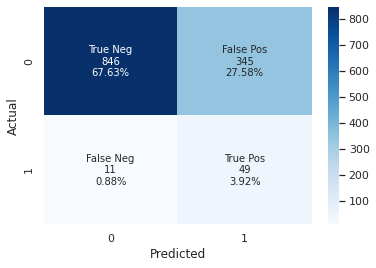

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1191
           1       0.12      0.82      0.22        60

    accuracy                           0.72      1251
   macro avg       0.56      0.76      0.52      1251
weighted avg       0.95      0.72      0.80      1251

Modelo:DecisionTreeClassifier


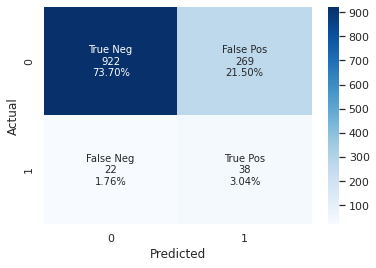

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1191
           1       0.12      0.63      0.21        60

    accuracy                           0.77      1251
   macro avg       0.55      0.70      0.54      1251
weighted avg       0.94      0.77      0.83      1251

Modelo:RandomForestClassifier


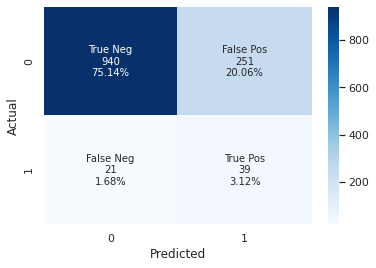

              precision    recall  f1-score   support

           0       0.98      0.79      0.87      1191
           1       0.13      0.65      0.22        60

    accuracy                           0.78      1251
   macro avg       0.56      0.72      0.55      1251
weighted avg       0.94      0.78      0.84      1251

Modelo:KNeighborsClassifier


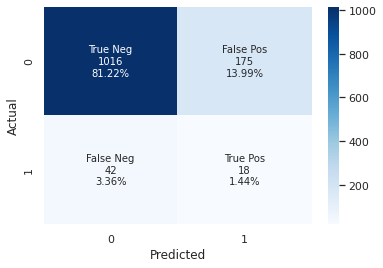

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1191
           1       0.09      0.30      0.14        60

    accuracy                           0.83      1251
   macro avg       0.53      0.58      0.52      1251
weighted avg       0.92      0.83      0.87      1251

[0]	validation_0-error:0.205436
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.181455
[2]	validation_0-error:0.191847
[3]	validation_0-error:0.192646
[4]	validation_0-error:0.183054
[5]	validation_0-error:0.189448
[6]	validation_0-error:0.189448
Stopping. Best iteration:
[1]	validation_0-error:0.181455

Modelo:XGBClassifier


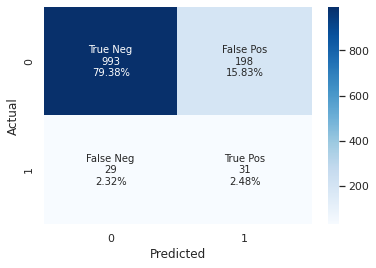

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      1191
           1       0.14      0.52      0.21        60

    accuracy                           0.82      1251
   macro avg       0.55      0.68      0.56      1251
weighted avg       0.93      0.82      0.86      1251



/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/500
224/224 [==============================] - 14s 4ms/step - loss: 0.5686 - recall: 0.6859 - val_loss: 0.4723 - val_recall: 0.8641
Epoch 2/500
224/224 [==============================] - 0s 2ms/step - loss: 0.4467 - recall: 0.8656 - val_loss: 0.5572 - val_recall: 0.8668
Epoch 3/500
224/224 [==============================] - 0s 2ms/step - loss: 0.4364 - recall: 0.8682 - val_loss: 0.4946 - val_recall: 0.8697


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

Modelo:Artificial Neural Network


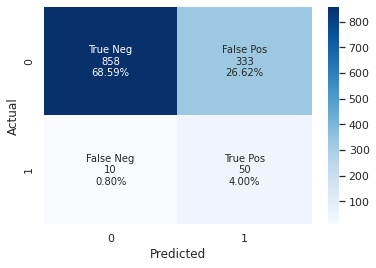

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1191
           1       0.13      0.83      0.23        60

    accuracy                           0.73      1251
   macro avg       0.56      0.78      0.53      1251
weighted avg       0.95      0.73      0.80      1251



In [ ]:
for key in models:
  grid_model = GridSearchCV(estimator=models[key]['Modelo'],param_grid=models[key]['Params'],n_jobs=-1,cv=5,scoring='recall')
  if key=='Artificial Neural Network':
    grid_model.fit(X_train_smote,y_train_smote,callbacks=[monitor_val_recall],validation_data=(X_test,y_test))
  elif key=='XGBClassifier':
    grid_model.fit(X_train_smote,y_train_smote,early_stopping_rounds=5, eval_set=[(X_test,y_test)])
  else:
    grid_model.fit(X_train_smote,y_train_smote)
  models[key]['Modelo'] = grid_model.best_estimator_
  y_preds_train = grid_model.predict(X_train_smote)
  y_preds = grid_model.predict(X_test)
  y_preds_proba = grid_model.predict_proba(X_test)[:, 1]
  
  print("Modelo:" + key)
  classificationMatrix(y_test,y_preds)
  #rocCourveDisplay(y_preds,y_preds_proba,key)
  model_result.append([key,
                      accuracy_score(y_train_smote, y_preds_train),
                      precision_score(y_train_smote, y_preds_train),
                      recall_score(y_train_smote, y_preds_train),
                      f1_score(y_train_smote, y_preds_train),
                      accuracy_score(y_test, y_preds),
                      precision_score(y_test, y_preds),
                      recall_score(y_test, y_preds),
                      f1_score(y_test, y_preds),
                      roc_auc_score(y_test,y_preds)]                     
                      )

 # Results

In [ ]:
resumen_modelos = pd.DataFrame(model_result,columns=['Modelo','Train_Accuracy','Train_Precision','Train_Recall','Train_F1_Score','Test_Accuracy','Test_Precision','Test_Recall','Test_F1_Score','Test_Auc_Score'])

In [ ]:
resumen_modelos[['Modelo','Train_Accuracy','Train_Recall','Test_Accuracy','Test_Recall','Test_Auc_Score']].sort_values(["Test_Recall","Test_Auc_Score"],ascending=False)

,Modelo,Train_Accuracy,Train_Recall,Test_Accuracy,Test_Recall,Test_Auc_Score
5,Artificial Neural Network,0.802996,0.882386,0.725819,0.833333,0.776868
0,LogisticRegression,0.796976,0.875945,0.715428,0.816667,0.763497
2,RandomForestClassifier,0.877905,0.937553,0.782574,0.650000,0.719626
1,DecisionTreeClassifier,0.850182,0.905629,0.767386,0.633333,0.703736
4,XGBClassifier,0.875105,0.909549,0.818545,0.516667,0.675210
3,KNeighborsClassifier,1.000000,1.000000,0.826539,0.300000,0.576532
